# Algorithm 2

In [1]:
from trajectory_generator import *
from functions import *
import numpy as np
import matplotlib.pyplot as plt
from cmap import Colormap
from scipy.special import comb
from itertools import combinations_with_replacement
from collections import Counter

## Figure of trajectories

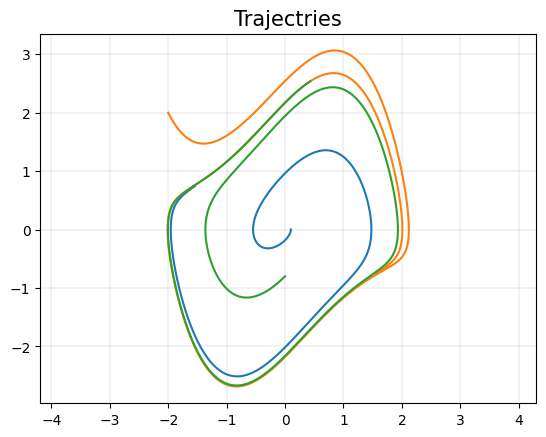

In [2]:
#change font size in figures
plt.rc('axes', titlesize=15) 
plt.rc('legend', fontsize=15) 

mu=1; model = VanderPol(mu); d=2 # Van der Pol oscillator
# alpha=-1; beta=1; delta=0.5; model=Duffing(alpha,beta,delta); d=2 # Duffing oscillator

# Trajectries of the dynamical system
ax=plt.figure().add_subplot()
x0 = np.array([[0.1,0],[-2,2],[0,-0.8]]).T #initial values of (0.1, 0), (-1,1), and (0,-1)
traj = model.generate_trajectory(x0, t=10, h=1e-3)
ax.set_title("Trajectries")
ax.grid(True, linestyle='--', color='k', linewidth=0.1)
ax.plot(traj[:,0,:], traj[:,1,:])
ax.axis("equal")
plt.show()

## Computation of eigenvalues of estimated Perron-Frobenius operators

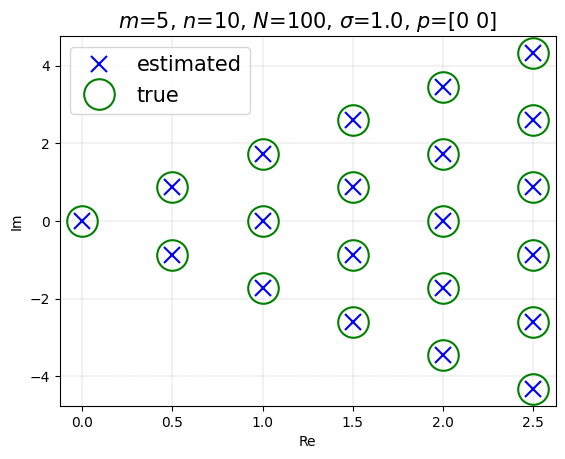

In [3]:
m = 5
n = 10
rm = comb(m+d,d, exact = True) # dimension of V_{p,m}
rn = comb(n+d,d, exact = True) # dimension of V_{p,n}
N = 100 # number of sample
kernel_name = 'exp' #'exp' or 'gauss'
assert kernel_name == 'exp' or  kernel_name =='gauss', 'kernel_name should be exp or gauss'

# Data
## Uniformly random sapmling from [-1,1]^2
X = 2*np.random.rand(d,N) - 1 

## exact velocities at X
Y = model.vector_field(X)


# Computation of V_n^X and W_m^{X,Y}
# Computation of V_n^X and W_m^{X,Y}
if kernel_name=='exp':
  constV = constV_exp #V_n^X with exponential kernel
  constW = constW_exp #W_m^{X,Y} with exponential kernel
  sigma_kernel = 1.0 #sigma
elif kernel_name == 'gauss':
  constV = constV_gauss #V_n^X  with Gaussian kernel 
  constW = constW_gauss #W_m^{X,Y} with Gaussian kernel 
  sigma_kernel = 1.0 #sigma
p = np.array([[0,0]]).T #fixed point of the dynamical system
b = p #shift parameter of the exponential kernel 
V = constV(X, p, n, sigma_kernel, b) # V_n^X
W = constW(X, Y, p, m, sigma_kernel, b) # W_m^{X,Y}


#Computation of A-hat
A = (W@(np.linalg.pinv(V)))[:,:rm]

# Computation of eigenvalues of the objective matrices
evals_estimated, _ = np.linalg.eig(A)

# Jacobian matrix of the dynamical system at 0
dFp=model.jacmat_vf(p)

# eigenvalues of the Jacobian matrix of the vector field at 0
eval_dFp=np.linalg.eig(dFp)[0][0] 

# make the array of multiplications of eigenvalues
evals_true =np.array([np.sum(ell, axis=0) for ell in combinations_with_replacement([0 + 0j] + list(eval_dFp),m)]) 

ax=plt.figure().add_subplot()
ax.set_title(f'$m$={m}, $n$={n}, $N$={N}, $\sigma$={sigma_kernel}, $p$={p[:,0]}')
ax.grid(True, linestyle='--', color='k', linewidth=0.1)
ax.plot(evals_estimated.real, evals_estimated.imag,  'x', c='blue', markersize=12, markeredgewidth=1.5, label='estimated')
ax.plot(evals_true.real, evals_true.imag, 'go', alpha=1, markerfacecolor='none', markersize=22, markeredgewidth=1.5, label='true')
ax.set_xlabel('Re')
ax.set_ylabel('Im')
ax.legend()
plt.show()